# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [15]:
%cd assignments/assignment1

/home/denis/Source/colab/dlcourse_ai/assignments/assignment1


In [9]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [16]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [17]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [18]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [19]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for FullyConnectedLayer_0_W
Gradient check passed!
Checking gradient for FullyConnectedLayer_0_B
Gradient check passed!
Checking gradient for FullyConnectedLayer_2_W
Gradient check passed!
Checking gradient for FullyConnectedLayer_2_B
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [20]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for FullyConnectedLayer_0_W
Gradient check passed!
Checking gradient for FullyConnectedLayer_0_B
Gradient check passed!
Checking gradient for FullyConnectedLayer_2_W
Gradient check passed!
Checking gradient for FullyConnectedLayer_2_B
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [21]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
samples = 900
multiclass_accuracy(model_with_reg.predict(train_X[:samples]), train_y[:samples])

0.15

In [22]:
np.sum(train_y[:samples]==2)

135

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [27]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.299364, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303996, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.306916, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.295179, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.304208, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.294550, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.304028, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.291798, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303474, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.298647, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302627, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.304788, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297501, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300976, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.290628, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302745, Train acc

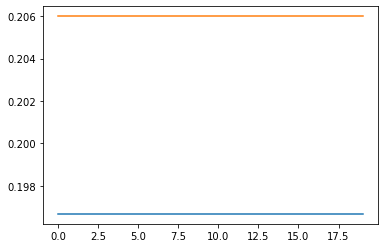

In [28]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [29]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.281337, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.296953, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.311361, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.312841, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.295474, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.241209, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.253498, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.341119, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.295631, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.224670, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.262271, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.182057, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.262760, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.272200, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.284177, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.260060, Train acc

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [30]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.311430, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.316921, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.308512, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.307118, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.314216, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.310917, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.290527, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.259834, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.288004, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.272567, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.227918, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.288148, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300996, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.246914, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.322529, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.288680, Train acc

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [31]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.331619, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.336105, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.321334, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.331523, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.294044, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.257004, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.298353, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.349459, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.279768, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 1.960522, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.928829, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.982798, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.218993, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.015133, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.962675, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.426123, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [32]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 400, reg = 1e-2)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=3e-1, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.327764, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.315370, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.235740, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.894580, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.349224, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 1.254980, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.193153, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.431534, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 1.953475, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 1.400409, Train accuracy: 0.600000, val accuracy: 0.000000
Loss: 1.280600, Train accuracy: 0.533333, val accuracy: 0.066667
Loss: 2.040854, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 1.642206, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 0.953880, Train accuracy: 0.733333, val accuracy: 0.000000
Loss: 1.244612, Train accuracy: 0.866667, val accuracy: 0.066667
Loss: 1.336350, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [33]:
# Let's train the best one-hidden-layer network we can

learning_rates = [1e-2]
reg_strengths = [1e-3, 1e-4]
learning_rate_decay = 0.995
hidden_layer_sizes = [100, 120, 150]
num_epochs = 40
batch_size = 64

best_classifier = None
best_val_accuracy = 0

loss_history = []
train_history = []
val_history = []

for hidden_layer_size in hidden_layer_sizes:
    for reg_strength in reg_strengths:
        for learning_rate in learning_rates:
            model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = hidden_layer_size, reg = reg_strength)
            dataset = Dataset(train_X, train_y, val_X, val_y)
            trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=learning_rate, num_epochs=num_epochs, batch_size=batch_size, learning_rate_decay=learning_rate_decay)

            loss_history, train_history, val_history = trainer.fit()
            if best_val_accuracy < val_history[-1]:
                print(f"new leader with val_acc={val_history[-1]} and params: [{hidden_layer_size=} {reg_strength=} {learning_rate=}]")
                best_val_accuracy = val_history[-1]
                best_classifier = model


print('best validation accuracy achieved: %f' % best_val_accuracy)

Loss: 2.173501, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.100491, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.278455, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.080153, Train accuracy: 0.261000, val accuracy: 0.259000
Loss: 2.029098, Train accuracy: 0.311000, val accuracy: 0.315000
Loss: 1.510735, Train accuracy: 0.391000, val accuracy: 0.388000
Loss: 1.827691, Train accuracy: 0.456667, val accuracy: 0.455000
Loss: 1.613189, Train accuracy: 0.519333, val accuracy: 0.517000
Loss: 1.156851, Train accuracy: 0.570444, val accuracy: 0.562000
Loss: 1.442326, Train accuracy: 0.605889, val accuracy: 0.607000
Loss: 1.447743, Train accuracy: 0.633222, val accuracy: 0.630000
Loss: 1.191157, Train accuracy: 0.653556, val accuracy: 0.643000
Loss: 1.219033, Train accuracy: 0.686000, val accuracy: 0.675000
Loss: 0.856997, Train accuracy: 0.701111, val accuracy: 0.667000
Loss: 0.980743, Train accuracy: 0.713000, val accuracy: 0.693000
Loss: 1.060762, Train acc

KeyboardInterrupt: 

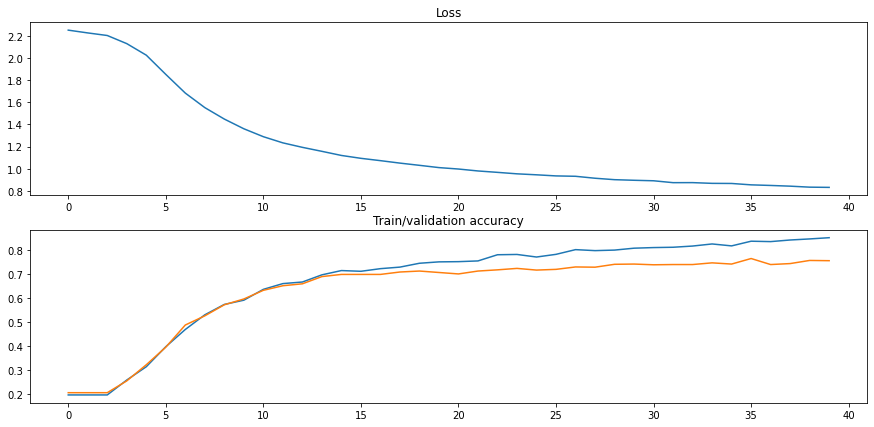

In [34]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [35]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.723000


new leader with val_acc=0.759 and params: [hidden_layer_size=150 reg_strength=0.001 learning_rate=0.01]